In [ ]:
# Install necessary packages. Run this cell at the top of the Colab notebook.
!pip install --quiet pandas numpy matplotlib scikit-learn streamlit==1.26.0 evidently==0.2.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# Create a sample dataset with numeric, categorical, missing values, duplicates and an outlier.
import os
import numpy as np
import pandas as pd

# Create output folder
out_dir = "/content/ai_data_analyzer_demo"
os.makedirs(out_dir, exist_ok=True)

np.random.seed(42)
n = 200

# Numeric columns
age = np.random.normal(loc=40, scale=12, size=n).round().astype(float)
age[[5, 20, 50]] = np.nan    # introduce missing values
income = np.random.normal(loc=70000, scale=20000, size=n).round(2)
income[2] = 1_000_000.0      # outlier
income[[10, 77]] = np.nan    # missing incomes
score = np.random.beta(a=2, b=5, size=n) * 100
score[[3, 99]] = np.nan

# Categorical columns
gender = np.random.choice(["Male", "Female", None], size=n, p=[0.48, 0.48, 0.04])
city = np.random.choice(["New York", "Chicago", "San Francisco", "Austin"], size=n, p=[0.3,0.25,0.2,0.25])

# Build rows and add a few duplicates
rows = []
for i in range(n):
    rows.append({"age": age[i], "income": income[i], "score": score[i], "gender": gender[i], "city": city[i]})
rows.extend(rows[0:3])  # duplicate the first 3 rows

df = pd.DataFrame(rows)
csv_path = os.path.join(out_dir, "data.csv")
df.to_csv(csv_path, index=False)

print("Sample CSV saved to:", csv_path)
df.head()


Sample CSV saved to: /content/ai_data_analyzer_demo/data.csv


,age,income,score,gender,city
0,46.0,77155.75,8.867416,Male,Chicago
1,38.0,81215.69,25.975742,Female,New York
2,48.0,1000000.00,15.769076,Male,Austin
3,58.0,91076.04,NaN,Female,Austin
4,37.0,42446.61,4.383396,None,Chicago


In [ ]:
import pandas as pd
df = pd.read_csv(csv_path)   # load the CSV we created
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())
df.head()


Shape: (203, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     200 non-null    float64
 1   income  201 non-null    float64
 2   score   201 non-null    float64
 3   gender  196 non-null    object 
 4   city    203 non-null    object 
dtypes: float64(3), object(2)
memory usage: 8.1+ KB
None

Missing values per column:
age       3
income    2
score     2
gender    7
city      0
dtype: int64


,age,income,score,gender,city
0,46.0,77155.75,8.867416,Male,Chicago
1,38.0,81215.69,25.975742,Female,New York
2,48.0,1000000.00,15.769076,Male,Austin
3,58.0,91076.04,NaN,Female,Austin
4,37.0,42446.61,4.383396,NaN,Chicago


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Make a copy to preserve original
clean = df.copy()

# 1) Drop exact duplicates
dupe_count = clean.duplicated(keep='first').sum()
print("Duplicate rows found:", dupe_count)
clean = clean.drop_duplicates(keep='first').reset_index(drop=True)

# 2) Identify numeric and categorical columns
num_cols = clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = clean.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# 3) Impute numeric columns using median (robust to outliers)
num_imputer = SimpleImputer(strategy="median")
clean[num_cols] = num_imputer.fit_transform(clean[num_cols])

# 4) Impute categorical columns using mode (most frequent)
for c in cat_cols:
    if clean[c].isna().any():
        mode_val = clean[c].mode(dropna=True)
        fill = mode_val.iloc[0] if not mode_val.empty else "Unknown"
        clean[c] = clean[c].fillna(fill)

print("\nMissing values after imputation:")
print(clean.isna().sum())


Duplicate rows found: 3
Numeric columns: ['age', 'income', 'score']
Categorical columns: ['gender', 'city']

Missing values after imputation:
age       0
income    0
score     0
gender    0
city      0
dtype: int64


In [ ]:
# Outlier detection using IQR
outlier_flags = pd.DataFrame(index=clean.index)
for c in num_cols:
    Q1 = clean[c].quantile(0.25)
    Q3 = clean[c].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_flags[c + "_outlier"] = (clean[c] < lower) | (clean[c] > upper)

outlier_summary = outlier_flags.sum().reset_index()
outlier_summary.columns = ["flag", "count"]
outlier_summary


,flag,count
0,age_outlier,3
1,income_outlier,3
2,score_outlier,1


In [ ]:
clean_csv_path = os.path.join(out_dir, "data_cleaned.csv")
clean.to_csv(clean_csv_path, index=False)
print("Cleaned CSV saved to:", clean_csv_path)


Cleaned CSV saved to: /content/ai_data_analyzer_demo/data_cleaned.csv


In [ ]:
# Summary statistics
summary_stats = clean[num_cols].agg(["mean","median","std","min","max"]).T.reset_index()
summary_stats.columns = ["feature","mean","median","std","min","max"]
print(summary_stats.to_string(index=False))

# Correlation matrix (Pearson)
corr = clean[num_cols].corr(method="pearson")
print("\nCorrelation matrix:")
print(corr)

# Top absolute correlations (excluding self)
corr_abs = corr.abs().where(~np.eye(len(corr), dtype=bool)).stack().reset_index()
corr_abs.columns = ["feature_1","feature_2","abs_corr"]
top_corr = corr_abs.sort_values("abs_corr", ascending=False).head(10)
print("\nTop correlations (abs):")
print(top_corr.to_string(index=False))


feature         mean       median          std         min            max
    age    39.405000    40.000000    11.147750    9.000000      73.000000
 income 76277.759400 71576.785000 68524.051064 5174.650000 1000000.000000
  score    28.111142    25.602573    15.584725    1.309692      75.367643

Correlation matrix:
             age    income     score
age     1.000000  0.073751 -0.040251
income  0.073751  1.000000 -0.049933
score  -0.040251 -0.049933  1.000000

Top correlations (abs):
feature_1 feature_2  abs_corr
      age    income  0.073751
   income       age  0.073751
    score    income  0.049933
   income     score  0.049933
      age     score  0.040251
    score       age  0.040251


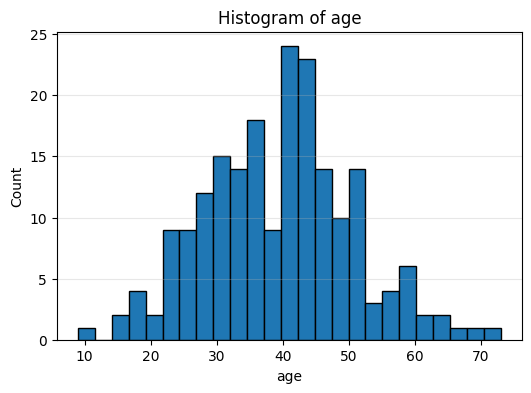

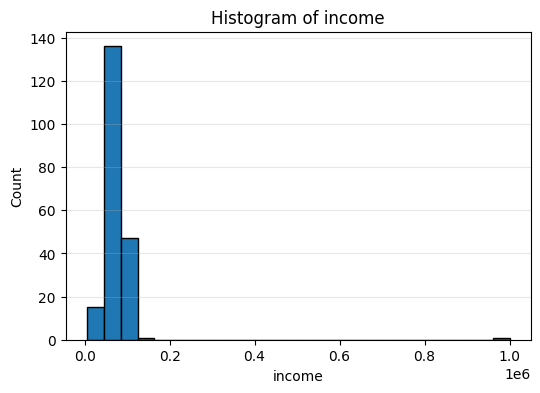

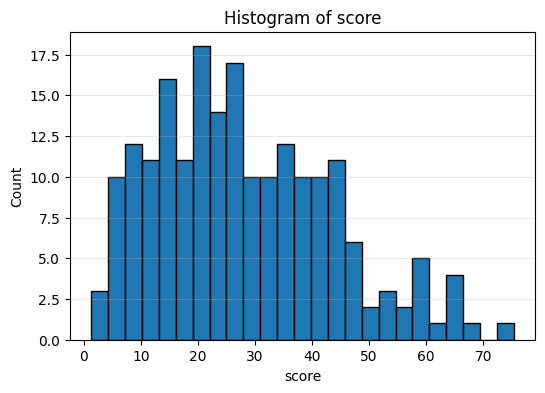

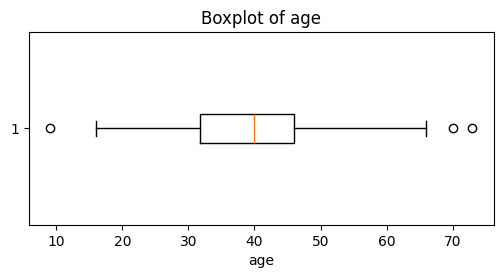

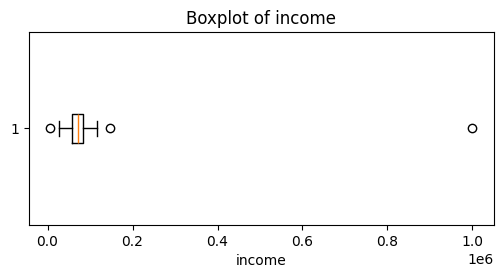

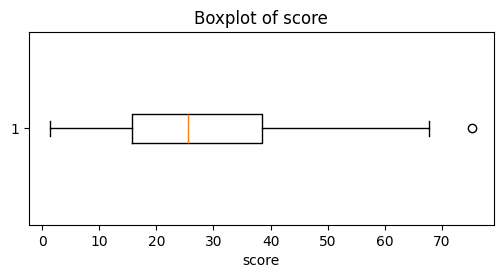

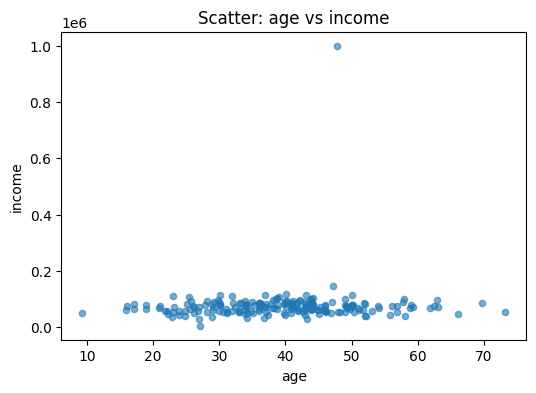

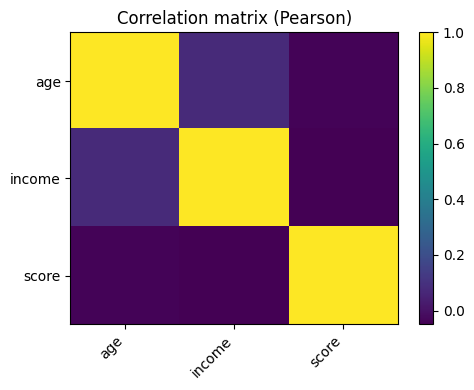

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots display inline in Colab
%matplotlib inline

# Histograms
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(clean[col], bins=25, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Boxplots
for col in num_cols:
    plt.figure(figsize=(6,2.5))
    plt.boxplot(clean[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Scatter: income vs age (use jitter to reduce overplot)
plt.figure(figsize=(6,4))
plt.scatter(clean["age"] + np.random.normal(0,0.15,size=len(clean)), clean["income"], alpha=0.6, s=20)
plt.title("Scatter: age vs income")
plt.xlabel("age")
plt.ylabel("income")
plt.show()

# Correlation heatmap (simple matplotlib imshow)
plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation matrix (Pearson)")
plt.tight_layout()
plt.show()


In [ ]:
insights = []

# Missing before cleaning
missing_before = df.isna().sum()
missing_cols = missing_before[missing_before > 0]
if not missing_cols.empty:
    insights.append("Columns with missing values before cleaning: " + ", ".join(f"{c}({int(m)})" for c,m in missing_cols.items()))
else:
    insights.append("No missing values before cleaning.")

# Outliers
outlier_counts = outlier_summary.set_index("flag")["count"].to_dict()
outlier_cols = {k.replace("_outlier",""):v for k,v in outlier_counts.items() if v>0}
if outlier_cols:
    insights.append("Detected outliers by feature (count): " + ", ".join(f"{k}({v})" for k,v in outlier_cols.items()))
else:
    insights.append("No outliers detected with IQR rule.")

# Strong correlations
strong_corrs = top_corr[top_corr["abs_corr"] > 0.5]
if not strong_corrs.empty:
    insights.append("Strong correlations (abs > 0.5): " + "; ".join(f'{r.feature_1} vs {r.feature_2} (|corr|={r.abs_corr:.2f})' for r in strong_corrs.itertuples()))
else:
    insights.append("No strong correlations (abs > 0.5).")

# Skewness
skewed = clean[num_cols].skew().abs().sort_values(ascending=False)
top_skewed = skewed[skewed > 1]
if not top_skewed.empty:
    insights.append("Highly skewed numeric features (abs skew > 1): " + ", ".join(top_skewed.index.tolist()))
else:
    insights.append("No highly skewed numeric features (abs skew > 1).")

for item in insights:
    print("- " + item)


- Columns with missing values before cleaning: age(3), income(2), score(2), gender(7)
- Detected outliers by feature (count): age(3), income(3), score(1)
- No strong correlations (abs > 0.5).
- Highly skewed numeric features (abs skew > 1): income


In [ ]:
# Create a small metrics CSV that we can append to each time we run the pipeline
metrics_path = os.path.join(out_dir, "metrics.csv")

# Example metric row (you would append new rows over time in real use)
import datetime
metrics_row = {
    "timestamp": datetime.datetime.utcnow().isoformat(),
    "n_rows_raw": len(df),
    "n_rows_clean": len(clean),
    "n_missing_before": int(df.isna().sum().sum()),
    "n_missing_after": int(clean.isna().sum().sum()),
    "n_duplicates": int(dupe_count),
}

# Write CSV (create if not exists, else append)
import csv
file_exists = os.path.isfile(metrics_path)
with open(metrics_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(metrics_row.keys()))
    if not file_exists:
        writer.writeheader()
    writer.writerow(metrics_row)

print("Metrics saved to:", metrics_path)


Metrics saved to: /content/ai_data_analyzer_demo/metrics.csv


/tmp/ipython-input-4183043992.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat(),


In [ ]:
%%bash
cat > /content/ai_data_analyzer_demo/streamlit_app.py <<'PY'
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import os

st.title("AI Data Analyzer - Monitoring Dashboard")

base = "/content/ai_data_analyzer_demo"
data_path = os.path.join(base, "data_cleaned.csv")
metrics_path = os.path.join(base, "metrics.csv")

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    st.subheader("Cleaned Data Preview")
    st.dataframe(df.head())

if os.path.exists(metrics_path):
    metrics = pd.read_csv(metrics_path, parse_dates=["timestamp"])
    st.subheader("Metrics Over Time")
    st.line_chart(metrics.set_index("timestamp")[["n_rows_raw", "n_rows_clean"]])
    st.write(metrics.tail())

    st.subheader("Missingness Over Time")
    st.line_chart(metrics.set_index("timestamp")[["n_missing_before", "n_missing_after"]])

else:
    st.info("No metrics.csv found. Run the pipeline to generate metrics.")
PY


**Action Required:** Please add your `ngrok` authtoken to Colab Secrets.
1. Click the "🔑 Secrets" tab in the left panel.
2. Add a new secret named `NGROK_AUTH_TOKEN`.
3. Paste your authtoken from [https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken) as the value.

In [ ]:
from google.colab import userdata
from pyngrok import ngrok

# Get the ngrok authtoken from Colab Secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

if NGROK_AUTH_TOKEN:
    # Authenticate ngrok
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("ngrok authtoken set.")
else:
    print("ngrok authtoken not found in Colab Secrets.")
    print("Please add it as a secret named 'NGROK_AUTH_TOKEN'.")

ngrok authtoken set.


In [ ]:
!pip install pyngrok -q

In [ ]:
from pyngrok import ngrok
import os
import subprocess
import time

# Terminate open tunnels if any
print("Terminating open tunnels...")
ngrok.kill()

# Set up ngrok tunnel
print("Setting up ngrok tunnel...")
# Ensure your Streamlit app file path is correct
streamlit_app_path = os.path.join(out_dir, "streamlit_app.py")

# Run Streamlit in the background using python -m
print(f"Running Streamlit app from: {streamlit_app_path}")
process = subprocess.Popen(["python", "-m", "streamlit", "run", streamlit_app_path])

# Give Streamlit a moment to start
time.sleep(5)

# Open a ngrok tunnel to the Streamlit port (default is 8501)
port = 8501
public_url = ngrok.connect(port).public_url
print(f"Streamlit app running at: {public_url}")

Terminating open tunnels...
Setting up ngrok tunnel...
Running Streamlit app from: /content/ai_data_analyzer_demo/streamlit_app.py
Streamlit app running at: https://prerailway-tyisha-uncharmable.ngrok-free.dev
